<a href="https://colab.research.google.com/github/mithilreddy369/Heart-Disease-Prediction/blob/main/Heart_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [183]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

#1. Data Collection

In [184]:


data = pd.read_csv('heart.csv')


In [185]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [186]:
row_index = 5  # Replace 5 with the desired row number (starting from 0)
specific_row = data.iloc[row_index]
print(specific_row)

age          58.0
sex           0.0
cp            0.0
trestbps    100.0
chol        248.0
fbs           0.0
restecg       0.0
thalach     122.0
exang         0.0
oldpeak       1.0
slope         1.0
ca            0.0
thal          2.0
target        1.0
Name: 5, dtype: float64


#2. Data Preprocessing

##2.1 Data Exploration
The dataset was thoroughly examined to ensure its integrity and readiness for analysis. Key steps included checking for missing values, verifying data types, and generating summary statistics. The dataset was found to be complete, with no missing entries, which facilitated a straightforward preprocessing workflow.

In [187]:
data.isnull().sum()


,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


##2.2 Encoding Categorical Variables
Categorical variables, such as cp, restecg, slope, ca, and thal, were transformed using one-hot encoding. This process was essential for converting categorical data into a numerical format suitable for machine learning algorithms.

In [188]:
data = pd.get_dummies(data, columns=['cp', 'restecg', 'slope', 'ca', 'thal'])


##2.3 Feature Scaling
Numerical features, including age, trestbps, chol, thalach, and oldpeak, were standardized to ensure consistency in their scale. This step involved adjusting the features to have a mean of 0 and a standard deviation of 1, thereby enhancing the model's ability to learn effectively.

In [189]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']] = scaler.fit_transform(data[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']])


In [190]:
print(data.columns)

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak',
       'target', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'restecg_0', 'restecg_1',
       'restecg_2', 'slope_0', 'slope_1', 'slope_2', 'ca_0', 'ca_1', 'ca_2',
       'ca_3', 'ca_4', 'thal_0', 'thal_1', 'thal_2', 'thal_3'],
      dtype='object')


##2.4 Data Splitting
The preprocessed data was partitioned into training and testing sets using a stratified split. This method preserved the distribution of the target variable across the splits, ensuring that the model evaluation would be both reliable and representative of its performance on unseen data.

In [191]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#3. Handling Class Imbalance
To address the issue of class imbalance in the dataset, Synthetic Minority Over-sampling Technique (SMOTE) was employed. SMOTE generates synthetic samples for the minority class, enhancing the model’s ability to learn from a more balanced dataset. This technique was essential to prevent the model from becoming biased towards the majority class, thereby improving its predictive performance.



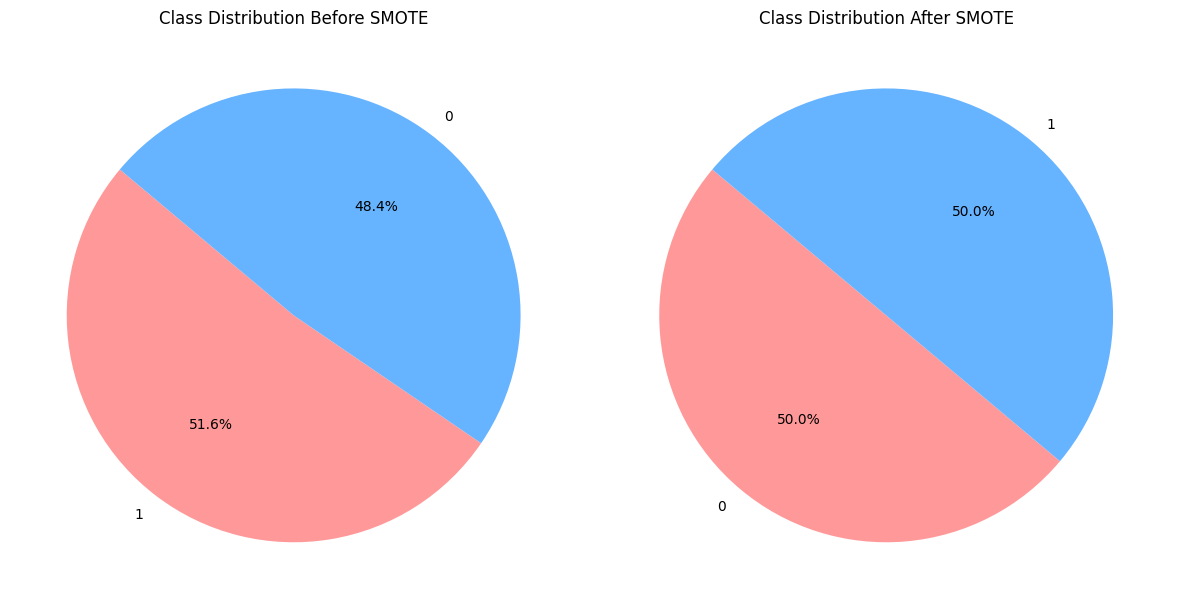

In [192]:
import matplotlib.pyplot as plt

# Class distribution before SMOTE
before_counts = y_train.value_counts()
before_labels = before_counts.index
before_sizes = before_counts.values

# Apply SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Class distribution after SMOTE
after_counts = y_train_balanced.value_counts()
after_labels = after_counts.index
after_sizes = after_counts.values

# Plot Pie Charts
plt.figure(figsize=(12, 6))

# Pie chart before SMOTE
plt.subplot(1, 2, 1)
plt.pie(before_sizes, labels=before_labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Class Distribution Before SMOTE')

# Pie chart after SMOTE
plt.subplot(1, 2, 2)
plt.pie(after_sizes, labels=after_labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Class Distribution After SMOTE')

plt.tight_layout()
plt.show()


#4. Model Building
The stacked ensemble model was developed to enhance predictive performance by combining multiple base classifiers. A diverse set of six base models was chosen to capture different aspects of the data, improving overall accuracy and robustness. The predictions from these base models were used as input features for a meta-model, which synthesized their outputs to make the final prediction. This approach exploits the complementary strengths of various algorithms, resulting in a more effective ensemble model.

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report



# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)),
    ('svc', SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5, algorithm='auto', p=2)),  # p=2 for Euclidean distance
    ('log', LogisticRegression(max_iter=2000, C=0.5, solver='lbfgs', random_state=42)),
    ('et', ExtraTreesClassifier(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=2, random_state=42))
]

# Define meta-model
meta_model = LogisticRegression(max_iter=2000, C=0.5, solver='lbfgs')

# Create stacking classifier
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
stacked_model.fit(X_train_scaled, y_train)

# Predict and evaluate the stacked model
y_pred_stacked = stacked_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_stacked)
report = classification_report(y_test, y_pred_stacked)

# Output results
print(f"Stacked Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

# Cross-validation scores for base models
for name, model in base_models:
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"\n{name} Cross-Validation Scores: {cv_scores}")
    print(f"{name} Mean CV Accuracy: {cv_scores.mean():.4f}")

# Cross-validation scores for stacked model
stacked_cv_scores = cross_val_score(stacked_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nStacked Model Cross-Validation Mean Accuracy: {stacked_cv_scores.mean():.4f}")


Stacked Model Accuracy: 0.9854

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205


rf Cross-Validation Scores: [0.99390244 0.94512195 0.97560976 0.96341463 0.93292683]
rf Mean CV Accuracy: 0.9622

svc Cross-Validation Scores: [0.93902439 0.93292683 0.93902439 0.94512195 0.87804878]
svc Mean CV Accuracy: 0.9268

knn Cross-Validation Scores: [0.90243902 0.85365854 0.89634146 0.86585366 0.79878049]
knn Mean CV Accuracy: 0.8634

log Cross-Validation Scores: [0.87804878 0.85365854 0.8902439  0.92073171 0.81097561]
log Mean CV Accuracy: 0.8707

et Cross-Validation Scores: [0.99390244 0.94512195 0.94512195 0.95731707 0.90243902]
et Mean CV Accuracy: 0.9488

dt Cross-Validation Scores: [0.93292683 

Description of Base Models:

* RandomForestClassifier: A versatile ensemble method using multiple decision trees to improve accuracy and reduce overfitting.
* SVC (Support Vector Classifier): A classifier that finds the optimal hyperplane for separating classes, using probability estimates.
* KNeighborsClassifier: A non-parametric method that classifies based on the majority vote of neighboring samples.
* LogisticRegression: A linear model for binary classification, used as both a base model and meta-model for stacking.
* ExtraTreesClassifier: An ensemble method that creates multiple decision trees and averages their predictions, similar to Random Forest but with additional randomness.

* DecisionTreeClassifier: A simple classifier that splits the data based on feature values to form a decision tree.

#5. Model Accuracy Evaluation


##5.1 Accuracy Evaluation

The accuracy of each model was evaluated and visualized using a bar chart. This chart highlights the performance of individual base models compared to the stacked ensemble model. The stacked model achieved an accuracy of 98.5%, demonstrating superior performance relative to the base models. The bar chart provides a clear comparison, showcasing how well each model classifies the test data.

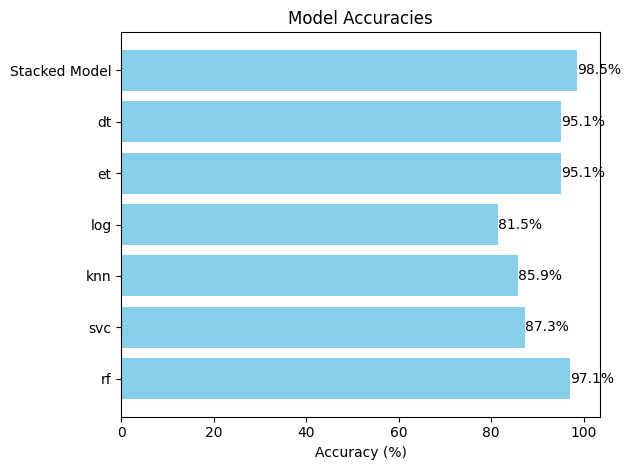

In [194]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Evaluate base models
base_model_accuracies = {}
for name, model in base_models:
    model.fit(X_train_balanced, y_train_balanced)
    y_pred_base = model.predict(X_test_scaled)  # Use X_test_scaled for consistency
    accuracy = accuracy_score(y_test, y_pred_base) * 100  # Convert to percentage
    base_model_accuracies[name] = accuracy

# Evaluate the stacked model
y_pred_stacked = stacked_model.predict(X_test_scaled)  # Use X_test_scaled for consistency
stacked_accuracy = accuracy_score(y_test, y_pred_stacked) * 100  # Convert to percentage
base_model_accuracies['Stacked Model'] = stacked_accuracy

# Plot Accuracy
plt.figure()
names = list(base_model_accuracies.keys())
scores = list(base_model_accuracies.values())
bars = plt.barh(names, scores, color='skyblue')

# Add percentage labels to bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.1f}%',
             va='center', ha='left', color='black')

plt.xlabel('Accuracy (%)')
plt.title('Model Accuracies')
plt.tight_layout()
plt.show()


##5.2 Precision, Recall, and F1-Score Metrics

The precision, recall, and F1-score for each model are summarized in a table. Precision reflects the proportion of true positive predictions among all positive predictions, while recall indicates the model's ability to identify actual positives. The F1-score combines precision and recall into a single metric. The table shows these metrics rounded to two decimal places, with the stacked model showing the highest scores across all metrics, underscoring its effectiveness in classification tasks.








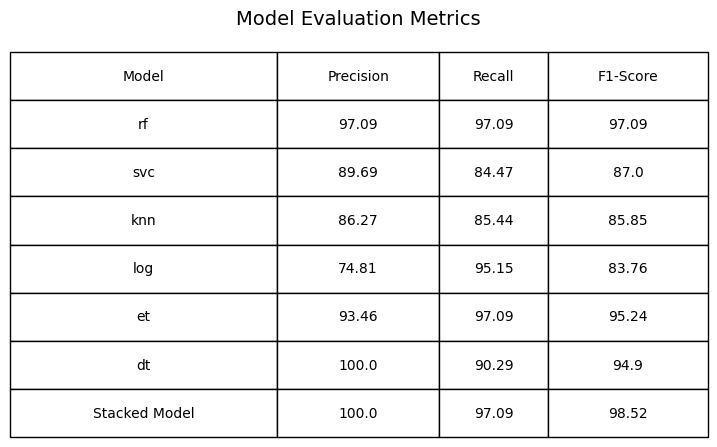

In [195]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize dictionaries to store metrics
metrics = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Evaluate base models
for name, model in base_models:
    model.fit(X_train_balanced, y_train_balanced)
    y_pred_base = model.predict(X_test_scaled)  # Use X_test_scaled for consistency
    precision = round(precision_score(y_test, y_pred_base) * 100, 2)  # Convert to percentage and round
    recall = round(recall_score(y_test, y_pred_base) * 100, 2)  # Convert to percentage and round
    f1 = round(f1_score(y_test, y_pred_base) * 100, 2)  # Convert to percentage and round
    metrics['Model'].append(name)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1-Score'].append(f1)

# Evaluate the stacked model
y_pred_stacked = stacked_model.predict(X_test_scaled)  # Use X_test_scaled for consistency
precision_stacked = round(precision_score(y_test, y_pred_stacked) * 100, 2)  # Convert to percentage and round
recall_stacked = round(recall_score(y_test, y_pred_stacked) * 100, 2)  # Convert to percentage and round
f1_stacked = round(f1_score(y_test, y_pred_stacked) * 100, 2)  # Convert to percentage and round
metrics['Model'].append('Stacked Model')
metrics['Precision'].append(precision_stacked)
metrics['Recall'].append(recall_stacked)
metrics['F1-Score'].append(f1_stacked)

# Create DataFrame for better visualization
metrics_df = pd.DataFrame(metrics)

# Plot table
fig, ax = plt.subplots(figsize=(9, 5))  # Adjust the size of the figure
ax.axis('tight')
ax.axis('off')
table_data = metrics_df.values
table = ax.table(cellText=table_data, colLabels=metrics_df.columns, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])

# Adjust font size and scale
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2, 3])

plt.title('Model Evaluation Metrics', fontsize=14, pad=20)
plt.show()


#6. Model Saving

In this stage, the trained machine learning models are saved to disk to facilitate future use without requiring re-training. For this purpose, the Python pickle library is utilized. pickle is a standard library in Python that enables serialization and deserialization of Python objects. It converts the trained model into a byte stream, which can be stored as a file and later reconstructed into the original model.

The process involves:

* Serialization: Using pickle, the trained model is serialized into a binary format and saved to a file. This allows the model to be stored efficiently and loaded later for predictions or further evaluation.

* Deserialization: When needed, the model can be loaded back into memory from the saved file using pickle. This restores the model to its original state, enabling its use in generating predictions on new data.

In [196]:
import pickle
from sklearn.preprocessing import StandardScaler

# Save the model and scaler
with open('model_and_scaler.pkl', 'wb') as file:
    pickle.dump({
        'model': stacked_model,
        'scaler': scaler
    }, file)


##Testing

In [198]:
import pandas as pd

data1 = pd.read_csv('heart.csv')


In [199]:
row_index = 5  # Replace 5 with the desired row number (starting from 0)
specific_row = data1.iloc[row_index]
print(specific_row)

age          58.0
sex           0.0
cp            0.0
trestbps    100.0
chol        248.0
fbs           0.0
restecg       0.0
thalach     122.0
exang         0.0
oldpeak       1.0
slope         1.0
ca            0.0
thal          2.0
target        1.0
Name: 5, dtype: float64


In [200]:
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the model and scaler
with open('model_and_scaler.pkl', 'rb') as file:
    data = pickle.load(file)
    loaded_model = data['model']
    scaler = data['scaler']

# Define your custom input data
custom_input = {
    'age': [58],
    'sex': [0],
    'cp': [0],
    'trestbps': [100],
    'chol': [248],
    'fbs': [0],
    'restecg': [0],
    'thalach': [122],
    'exang': [0],
    'oldpeak': [1],
    'slope': [1],
    'ca': [0],
    'thal': [2]
}

# Convert the dictionary to a DataFrame
custom_df = pd.DataFrame(custom_input)

# Apply one-hot encoding to match the training data's structure
custom_df = pd.get_dummies(custom_df, columns=['cp', 'restecg', 'slope', 'ca', 'thal'])

# Define the expected columns used during training
expected_columns = [
    'age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak',
    'cp_0', 'cp_1', 'cp_2', 'cp_3', 'restecg_0', 'restecg_1', 'restecg_2',
    'slope_0', 'slope_1', 'slope_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4',
    'thal_0', 'thal_1', 'thal_2', 'thal_3'
]

# Reindex to ensure all columns are present
custom_df = custom_df.reindex(columns=expected_columns, fill_value=0)

# Apply scaling to the custom data
custom_scaled = scaler.transform(custom_df)  # Transform using the loaded scaler

# Make a prediction using the loaded model
prediction = loaded_model.predict(custom_scaled)

# Output the prediction
print(f"Prediction for custom input: {prediction[0]}")


Prediction for custom input: 1
